In [53]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
#setting data directory

Datadirectory = "E:/University/Dataset/Pneumonia/chest_xray/"

Classes = ["NORMAL","BACTERIAL","VIRAL"]

img_size =224

# Data Preprocessing

In [4]:
#Converting all training data to array with labels

training_Data = [] 

def create_training_Data():
    
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)  #label 0,1,2 for classes

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR) #reading as RGB for Transfer Learning
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2Lab) #Conversion of RGB to LAB(L for lightness and a and b for the color opponents green–red and blue–yellow)
                clahe = cv2.createCLAHE(clipLimit=5) #applying CLAHE for contrast
                img_array[:,:,0] = clahe.apply(img_array[:,:,0])
                img_array = cv2.cvtColor(img_array, cv2.COLOR_Lab2RGB)
                
                new_array = cv2.resize(img_array, (img_size,img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass 

In [5]:
#creating training data

create_training_Data()

In [6]:
#shuffling data

import random

random.shuffle(training_Data)

In [7]:
#Splitting features and labels and converting features to numpy array

X = []
Y = []

for features,labels in training_Data:
    
    X.append(features)
    Y.append(labels)
    
print(len(X))
X = np.array(X).reshape(-1,img_size,img_size,3)
Y = np.array(Y)

5856


In [8]:
print(X.shape)
print(Y.shape)

(5856, 224, 224, 3)
(5856,)


In [9]:
#normalizing data

X = X/255.0

In [10]:
#saving data in .npy files

np.save('data', X)
np.save('label', Y)

# Explorative Data Analysis

In [11]:
Normal_path = "E:/University/Dataset/Pneumonia/chest_xray/NORMAL"
Bacterial_path = "E:/University/Dataset/Pneumonia/chest_xray/BACTERIAL"
Viral_path = "E:/University/Dataset/Pneumonia/chest_xray/VIRAL"


Text(0.5, 1.0, 'VIRAL (CLAHE)')

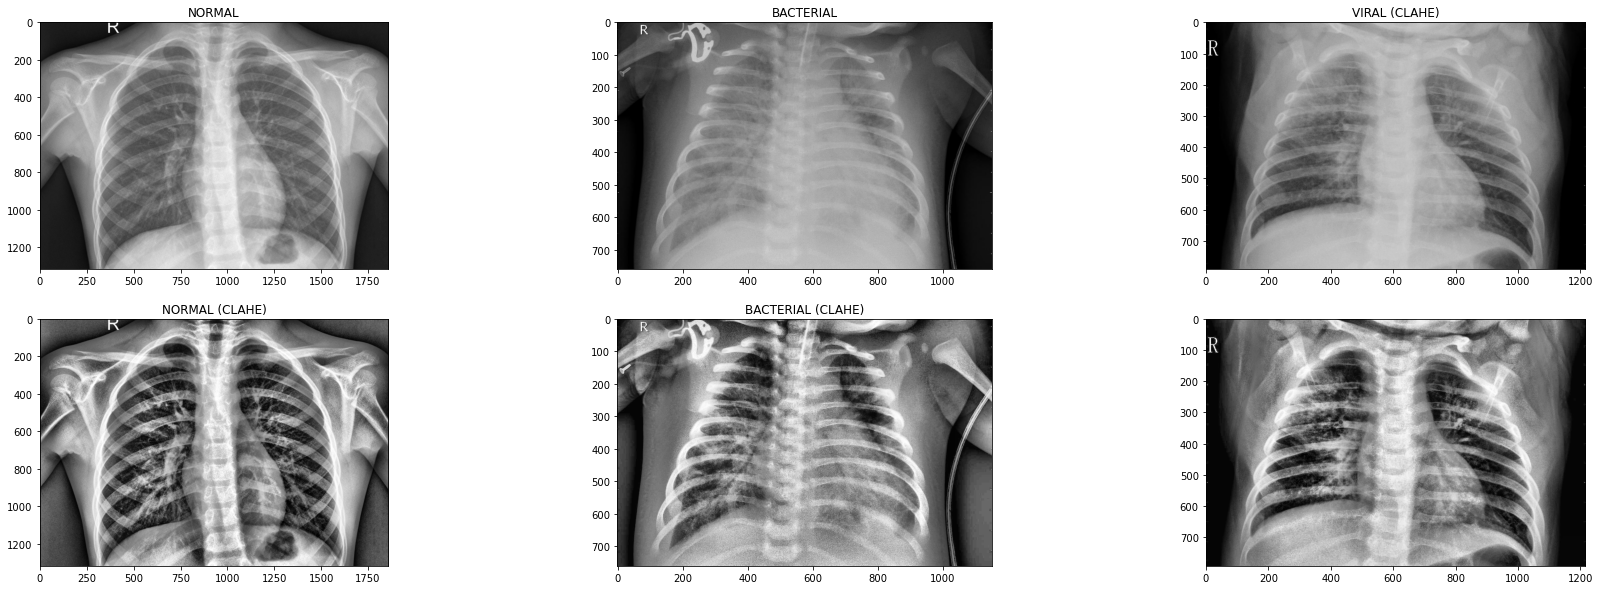

In [12]:
f, ax = plt.subplots(2,3, figsize=(30,10))

img = cv2.imread(os.path.join(Normal_path,os.listdir(Normal_path)[0]), cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=5) 
final_img = clahe.apply(img)
ax[0,0].imshow(img, cmap='gray')
ax[1,0].imshow(final_img, cmap='gray')
ax[0,0].set_title("NORMAL")
ax[1,0].set_title("NORMAL (CLAHE)")

img = cv2.imread(os.path.join(Bacterial_path,os.listdir(Bacterial_path)[0]), cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=5) 
final_img = clahe.apply(img)
ax[0,1].imshow(img, cmap='gray')
ax[1,1].imshow(final_img, cmap='gray')
ax[0,1].set_title("BACTERIAL")
ax[1,1].set_title("BACTERIAL (CLAHE)")

img = cv2.imread(os.path.join(Viral_path,os.listdir(Viral_path)[3]), cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=5) 
final_img = clahe.apply(img)
ax[0,2].imshow(img, cmap='gray')
ax[1,2].imshow(final_img, cmap='gray')
ax[0,2].set_title("VIRAL")
ax[0,2].set_title("VIRAL (CLAHE)")

In [13]:
#X = np.load('data.npy')
Y = np.load('label.npy')

In [14]:
unique, counts = np.unique(Y, return_counts=True)
LabelCounts = dict(zip(unique, counts))

for key, value in LabelCounts.items():
    if(key==0):
        print(key, '(Normal) : ', value)
    
    elif(key==1):
        print(key, '(Bacterial) : ', value)
    
    else:
        print(key, '(Viral) : ', value)
# 0 --> Normal
# 1 --> Bacterial
# 2 --> Viral

0 (Normal) :  1583
1 (Bacterial) :  2780
2 (Viral) :  1493


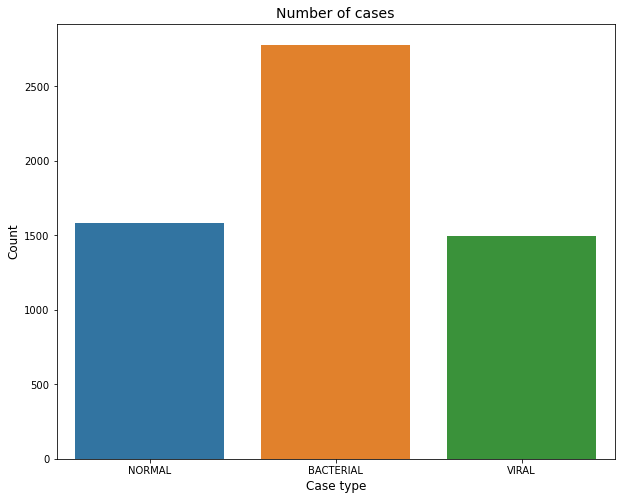

In [15]:
plt.figure(figsize=(10,8))
sns.barplot(x=unique, y= counts)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(unique)), ['NORMAL', 'BACTERIAL','VIRAL'])
plt.show()

# Data Splitting & Augmentation

In [48]:
X = np.load('data.npy')
Y = np.load('label.npy')

In [49]:
# Separate the test data
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Split the remaining data to train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [37]:
np.save('tdata', X_test)
np.save('tlabel', Y_test)

In [50]:
datagen = ImageDataGenerator(
        shear_range=0.15, #randomly change images angle of slant
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [66]:
class_weights = compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weights))
class_weights

{0: 1.2452642073778664, 1: 0.6981553940749021, 2: 1.3078534031413613}

# Model Creation


In [68]:
# initialize the initial learning rate, number of epochs, batch size
INIT_LR = 0.0001
EPOCHS = 10

In [69]:
# load the MobileNetV2 model excluding top layers (Transfer Learning)

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

In [70]:
# loop over all layers in the base model and freeze them so they will not be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

In [71]:
# construct the new model by adding base model then fully connected layers and output

model_MNV2 = Sequential()
model_MNV2.add(baseModel)
model_MNV2.add(GlobalAveragePooling2D())
model_MNV2.add(Dense(128, activation='relu'))
model_MNV2.add(Dropout(0.5))
model_MNV2.add(Dense(64, activation='relu'))
model_MNV2.add(Dropout(0.2))
model_MNV2.add(Dense(3, activation='softmax'))

In [72]:
#Model Compiling
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model_MNV2.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])


In [73]:
model_MNV2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 128)               163968    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [74]:
#Decrease lr when model converges 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3)

In [75]:
#Model Training 
H = model_MNV2.fit(datagen.flow(X_train,Y_train) ,
                    epochs = EPOCHS , validation_data = datagen.flow(X_val, Y_val) ,
                    callbacks = [learning_rate_reduction], class_weight=class_weights)

Epoch 1/10
118/118 [==============================] - 516s 4s/step - loss: 0.9508 - accuracy: 0.5380 - val_loss: 0.7416 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - 513s 4s/step - loss: 0.7358 - accuracy: 0.6429 - val_loss: 0.6880 - val_accuracy: 0.7172 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - 513s 4s/step - loss: 0.6939 - accuracy: 0.6712 - val_loss: 0.7018 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 4/10
118/118 [==============================] - 535s 5s/step - loss: 0.6781 - accuracy: 0.6912 - val_loss: 0.6668 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 5/10
118/118 [==============================] - 490s 4s/step - loss: 0.6429 - accuracy: 0.7115 - val_loss: 0.6188 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 6/10
118/118 [==============================] - 405s 3s/step - loss: 0.6578 - accuracy: 0.7035 - val_loss: 0.6358 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 7/10
118/118 [==============================] - 419s 4s/st

In [76]:
#saving the model

model_MNV2.save('Model_1_MNV2.h5')

# Result Visualization 


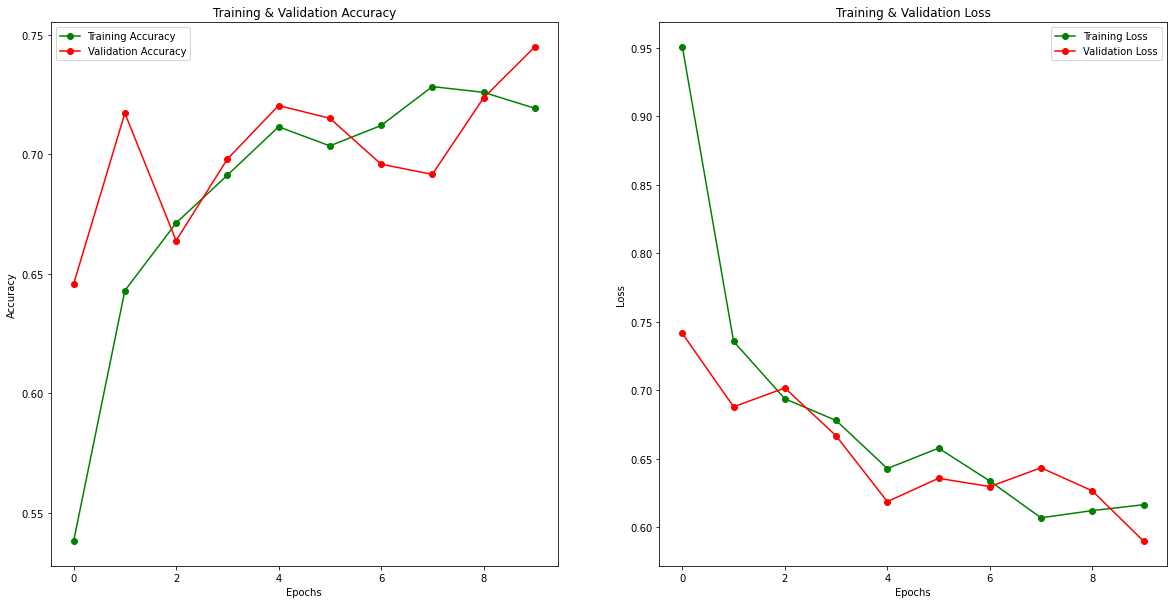

In [77]:
epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

train_acc = H.history['accuracy']
train_loss = H.history['loss']
val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']


ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Model Evaluation

In [78]:
tfeature = np.load('tdata.npy')
tlabel = np.load('tlabel.npy')

In [79]:
new_model = tf.keras.models.load_model("Model_1_MNV2.h5")

In [80]:
result = new_model.evaluate(tfeature,tlabel, verbose = 0)

[0.6373385787010193, 0.7312286496162415]

In [81]:
predictions = new_model.predict(tfeature)
predIdxs = np.argmax(predictions, axis=1)

In [82]:
print(classification_report(tlabel, predIdxs))

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       307
           1       0.82      0.75      0.79       565
           2       0.62      0.43      0.51       300

    accuracy                           0.73      1172
   macro avg       0.71      0.72      0.70      1172
weighted avg       0.73      0.73      0.72      1172



Text(69.0, 0.5, 'Actual')

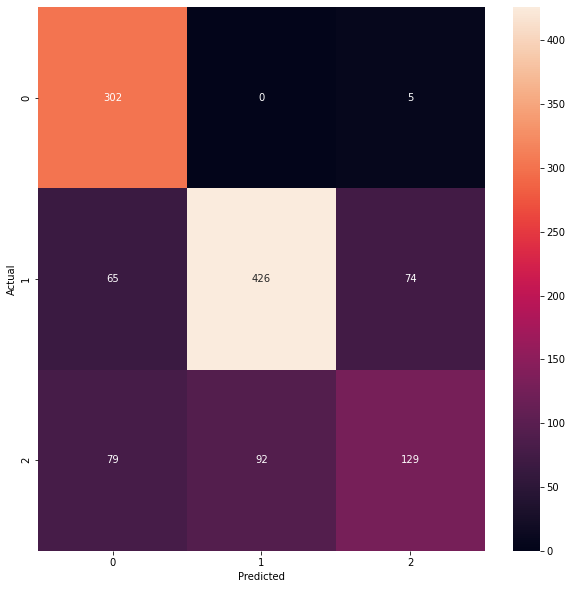

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(tlabel, predIdxs), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')